# 사용 라이브러리
- pandas version:  0.24.2
- numpy version:  1.16.2
- sklearn version:  0.21.2
- matplotlib version:  3.0.2
- seaborn version:  0.9.0
- pyecharts version:  0.5.8
- scipy version:  1.2.1
- tslearn version:  0.1.29

In [42]:
# preprocessing
import pandas as pd
import numpy as np 
from sklearn.preprocessing import MinMaxScaler
minmaxscaler = MinMaxScaler()

# visualization
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('fivethirtyeight')
import seaborn as sns
from pyecharts import Scatter3D, Pie, Bar, Timeline, Bar3D, Radar

# clustering
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram
from tslearn.clustering import TimeSeriesKMeans
from sklearn.manifold import TSNE

# Modeling
from sklearn.tree import DecisionTreeClassifier, plot_tree

# warnings
import warnings
warnings.filterwarnings('ignore')

# font
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
font_manager._rebuild()
mpl.rcParams['axes.unicode_minus'] = False

# 개요(Introduction)
&nbsp;&nbsp;본 과제에서는 전국민 카드 및 대출 이용 통계 데이터를 통해 그룹별 특성(성별|연령별 & 지역별|연령별)을 Time Series Clustering을 통해 군집 분석을 실행했고, 시각화를 통해 인사이트를 추출하고 군집들의 특징을 해석하기위해 머신러닝을 사용하였다.

# 사용데이터(Data)

사용 데이터 | 수집 기간 | 관측치 수 | 변수 수 | 참고 사항
---|---|---|---|---
전국민 카드 및 대출 이용통계 데이터 | 2016년 1월 ~ 2017년 12월 | 3,888 | 26 | 연령대/거주지/성별 구분에 따른 카드 및 대출 이용 통계 데이터

- Data source: KCB(Korea Credit Bureau)

## 데이터 참고사항
- 사용 데이터에서 개인정보에 대한 부분은 그룹별 통계량 및 그룹별 특성 데이터로 비식별화 되어있다. 데이터 사용에 있어서 10대와 90대의 경우 분석에서 제외한다.  


- **10대와 90대를 제외한 이유**
    - 10대 : 10대 데이터가 부분적으로 오류가 발생해 무시하고 작업
    - 90대 : 군집 분류를 위한 이상치로 판단. (낮은 빈도수, 금액 이상치)

- 전국민 카드 및 대출 이용통계 데이터(credit_card_data.csv)에는 서로 다른 표본으로 이루어진 성별&연령별 자료와 지역별&연령별 자료가 들어있다. 고객유형코드를 통해서 두 데이터를 분리하려 분석한다.

유형 | 수집 기간 | 관측치 수 | 변수 수 
---|---|---|---
성별&연령별 | 2016년 1월 ~ 2017년 12월 | 336 | 26 
지역별&연령별 | 2016년 1월 ~ 2017년 12월 | 2,688 | 26

# 분석방법(Methods)
- 전국민 카드 및 대출 이용 통계 데이터는 2016년 1월부터 2017년 12월까지의 데이터이다. 
- 그룹별 특성을 군집분석을 통해 파악하여 각 그룹별 어떤 특성을 갖는지 그래프를 통해 인사이트를 발견하고 머신러닝 방법을 통해 그룹별 특징을 해석한다. 

## Time Series Clustering (TSClustering)
- Time Series Clustering는 시간별 요소를 고려하기 때문에 시계열자료에서 군집분석을 할 때 사용되는 방법 중 하나이다. Time Series Clustering 을 통해 시간의 흐름에 따라 군집별 유형에 변화가 있는지 확인한다. 

- Euclidean vs Dinamic Time Wrapping(DTW)  

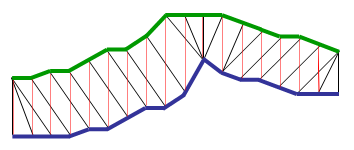

    - 시계열 모형1 : 초록색
    - 시계열 모형2 : 파란색
    - Euclidean : 붉은색
    - Dynamic Time Warping : 검은색

- Euclidean과 DTW는 시간별 흐름을 고려할 수 있는 거리 계산 방법이다. 위 그림은 Euclidean과 DTW의 차이를 보여준다. Euclidean은 같은 시점의 거리가 최단 거리이기 때문에 일대일 매칭이 된다.   
- 반면, DTW는 최단 거리를 가정 할 필요가 없다. DTW는 모든 점 사이의 최단 거리를 계산하기 때문에 일대다 매칭이 가능하다. 즉 여러 시점에 대해 어느 시점이 영향을 받는다. 

<그림 출처 :  *https://rpubs.com/esobolewska/dtw-time-series*>

- TSClustering에 사용될 변수는 카드사용 관련, 총 대출금액 관련, 업종별 대출금액, 일시/분할상환 대출잔여금액, 신용/담보 대출금액을 사용하였다. Clustering을 위해 변수마다 0~1 사이로 변환하였다. 스케일링은 월별 고객유형간 데이터를 변환하였다.

In [43]:
# Load Data
credit = pd.read_csv('credit_card_data.csv')
credit['date'] = pd.to_datetime(credit.apply(lambda x: '-'.join([str(x.year), str(x.month)]), axis=1))
raw_jeju = pd.read_csv('jeju_financial_life_data.csv')
# Remove Outliers
credit = credit.loc[(credit.ages!='10대')&(credit.ages!='90대')]
# Split Sex and City
credit_1 = credit[credit.pop_cd.apply(lambda x: True if 'Y' in x else False)]
credit_2 = credit[credit.pop_cd.apply(lambda x: True if 'L' in x else False)]
# raw data
credit_1_raw = credit_1.copy()
credit_2_raw = credit_2.copy()

In [44]:
features = ['num_opencard', 'num_usecard','monthly_card_spend', 'monthly_lc', 'monthly_loan', 'monthly_bk_loan',
            'monthly_cd_loan', 'monthly_installments_loan', 'monthly_insurance_loan', 'monthly_sbk_loan', 'loan_commitment',
            'inst_rep_loanb', 'ls_rep_loanb', 'credit_loan', 'mortgage_loan','credit_card_payment', 'credit_card_installments_payment']

# 성별&연령별 scaling
period = credit_1.date.unique()
for i in range(period.size):
    credit_1.loc[credit_1.date==period[i],features] = minmaxscaler.fit_transform(credit_1.loc[credit_1.date==period[i],features])
# 지역별&연령별 scaling    
period = credit_2.date.unique()
for i in range(period.size):
    credit_2.loc[credit_2.date==period[i],features] = minmaxscaler.fit_transform(credit_2.loc[credit_2.date==period[i],features])
    
# TSClustering에 맞는 데이터 형태로 변환 --> (고객유형 수, 날짜 수, 변수 수)

# 성별&연령별 
sex_cd = credit_1.pop_cd.unique()
sex_tsclust = np.zeros((credit_1.pop_cd.nunique(), 24, len(features)))
for i in np.arange(sex_cd.shape[0]):
    sex_tsclust[i] = credit_1.loc[credit_1.pop_cd==sex_cd[i],features]
# 지역별&연령별
region_cd = credit_2.pop_cd.unique()
region_tsclust = np.zeros((credit_2.pop_cd.nunique(), 24, len(features)))
for i in np.arange(region_cd.shape[0]):
    region_tsclust[i] = credit_2.loc[credit_2.pop_cd==region_cd[i],features]

In [45]:
ks = np.arange(1,10)
sex_inertias = list()
for k in ks:
    tsclust = TimeSeriesKMeans(n_clusters=k, metric='dtw',random_state=223).fit(sex_tsclust)
    sex_inertias.append(tsclust.inertia_)

114.268 --> 40.241 --> 40.241 --> 
53.285 --> 28.742 --> 28.742 --> 
15.434 --> 10.551 --> 10.551 --> 
13.520 --> 8.572 --> 8.014 --> 8.014 --> 
10.839 --> 5.671 --> 5.114 --> 5.114 --> 
8.409 --> 4.744 --> 4.174 --> 4.174 --> 
6.192 --> 3.854 --> 3.285 --> 3.285 --> 
4.183 --> 2.396 --> 2.396 --> 
3.013 --> 1.506 --> 1.506 --> 


In [46]:
ks = np.arange(1,10)
region_inertias = list()
for k in ks:
    tsclust = TimeSeriesKMeans(n_clusters=k, metric='dtw',random_state=223).fit(region_tsclust)
    region_inertias.append(tsclust.inertia_)

56.513 --> 27.889 --> 27.889 --> 
18.865 --> 15.307 --> 15.307 --> 
11.814 --> 8.479 --> 8.472 --> 8.472 --> 
9.275 --> 6.861 --> 6.462 --> 6.271 --> 6.178 --> 6.178 --> 
7.864 --> 6.230 --> 5.648 --> 5.339 --> 5.299 --> 5.280 --> 5.270 --> 5.270 --> 
6.747 --> 5.292 --> 4.870 --> 4.764 --> 4.683 --> 4.611 --> 4.600 --> 4.600 --> 
5.918 --> 4.570 --> 4.321 --> 4.296 --> 4.296 --> 
5.176 --> 3.699 --> 3.502 --> 3.469 --> 3.437 --> 3.437 --> 
4.962 --> 3.528 --> 3.315 --> 3.274 --> 3.242 --> 3.242 --> 


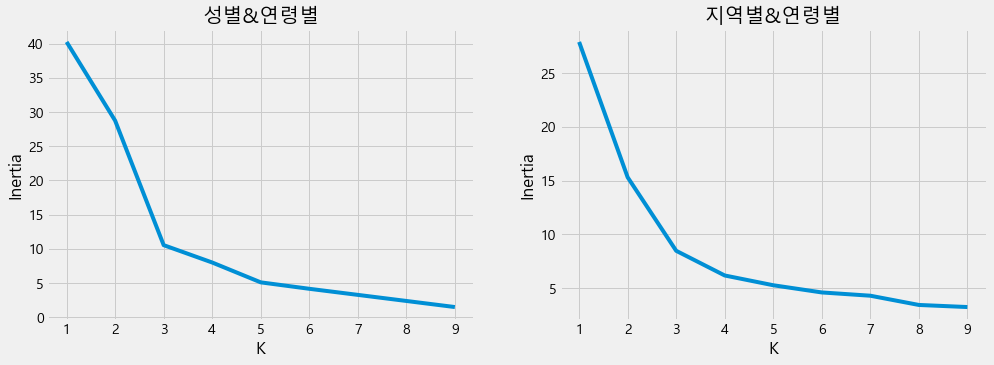

In [47]:
f, ax = plt.subplots(1,2, figsize=(15,5))
sns.lineplot(x=ks, y=sex_inertias, ax=ax[0])
sns.lineplot(x=ks, y=region_inertias, ax=ax[1])
ax[0].set_xlabel('K')
ax[1].set_xlabel('K')
ax[0].set_ylabel('Inertia')
ax[1].set_ylabel('Inertia')
ax[0].set_title('성별&연령별')
ax[1].set_title('지역별&연령별')
plt.show()

Inertia value는 군집의 중심점으로부터의 각 데이터들의 거리를 합산한 값을 말하며, 이 값이 작을 수록 응집력이 높다고 할 수 있다. 위와 같이 TSClustering을 K를 1부터 9까지 하였을 때 추출된 결과를 봤을때 성별&연령별은 5개의 군집이 적절해 보이고, 지역별&연령별은 4개의 군집이 적절해 보인다.

In [48]:
# 성별&연령별
tsclust = TimeSeriesKMeans(n_clusters=5, metric='dtw', random_state=223)
labels = tsclust.fit_predict(sex_tsclust)
sex_tsclust = pd.DataFrame({"pop_cd":credit_1.pop_cd.unique(), "label":labels})
credit_1 = pd.merge(credit_1, sex_tsclust, on='pop_cd', how='left')

# 지역별&연령별
tsclust = TimeSeriesKMeans(n_clusters=4, metric='dtw', random_state=223)
labels = tsclust.fit_predict(region_tsclust)
region_tsclust = pd.DataFrame({"pop_cd":credit_2.pop_cd.unique(), "label":labels})
credit_2 = pd.merge(credit_2, region_tsclust, on='pop_cd', how='left')

10.839 --> 5.671 --> 5.114 --> 5.114 --> 
9.275 --> 6.861 --> 6.462 --> 6.271 --> 6.178 --> 6.178 --> 


# 결과(Result)

## T-SNE를 통한 군집별 시각화 

In [49]:
# 성별&연령별
model = TSNE(n_components=3, random_state=223)
tsne_data_sex = model.fit_transform(credit_1[features])
tsne_data_sex = pd.concat([pd.DataFrame(tsne_data_sex, columns=['v1','v2','v3']) ,credit_1.label], axis=1)
tsne_data_sex.iloc[:,:-1] = minmaxscaler.fit_transform(tsne_data_sex.iloc[:,:-1]) * 100

# 지역별&연령별
model = TSNE(n_components=3, random_state=223)
tsne_data_region = model.fit_transform(credit_2[features])
tsne_data_region = pd.concat([pd.DataFrame(tsne_data_region, columns=['v1','v2','v3']) ,credit_2.label], axis=1)
tsne_data_region.iloc[:,:-1] = minmaxscaler.fit_transform(tsne_data_region.iloc[:,:-1]) * 100

In [50]:
color_map = {0:'orange',1:'black',2:'red',3:'blue',4:'green'}
colors = tsne_data_sex.label.map(color_map).to_list()
    
scatter3D = Scatter3D("성별&연령별 T-SNE", width=800, height=600)
scatter3D.add("", tsne_data_sex.drop('label',axis=1).values, is_visualmap=True, visual_range_color=colors)
scatter3D

변수를 3차원으로 축소하여 시각화하였을 때, TSClustering으로 분류된 군집별로 잘 묶여있는 것을 확인할 수 있다.

In [51]:
color_map = {0:'orange',1:'black',2:'red',3:'blue'}
colors = tsne_data_region.label.map(color_map).to_list()
    
scatter3D = Scatter3D("지역별&연령별 T-SNE", width=800, height=600)
scatter3D.add("", tsne_data_region.drop('label',axis=1).values, is_visualmap=True, visual_range_color=colors)
scatter3D

변수를 3차원으로 축소하여 시각화하였을 때, TSClustering으로 분류된 군집별로 잘 묶여있는 것을 확인할 수 있다.

In [52]:
credit_1_raw['label'] = credit_1.label.values
credit_2_raw['label'] = credit_2.label.values

## 그룹별 특성
### 성별&연령별 특성
#### 1. 군집분석 결과  
- 아래는 성별&연령별 군집의 분포, 시간별 군집의 유형 변화를 시각화한 자료이다.

In [53]:
%%html
<div class='tableauPlaceholder' id='viz1562517616950' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;se&#47;sex_age&#47;6&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='sex_age&#47;6' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;se&#47;sex_age&#47;6&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='filter' value='publish=yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1562517616950');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.maxWidth='850px';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';vizElement.style.maxHeight='787px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

- 위에 성별&연령별 군집 분포를 연령별로 보았을 때 크게 20대 / 30~50대 / 60~70대 / 70~80대로 나뉘는 것을 알 수 있고
- 성별을 고려해서 보았을 때 30~50대에서 남녀로 나눠지고, 남자의 경우 60~70대, 여자의 경우 70~80대로 묶여있다.
    - 군집0: 20대(남/여)
    - 군집1: 60대(남/여), 70대(남)
    - 군집2: 30~50대(남)
    - 군집3: 70대(여), 70~80대(남/여)
    - 군집4: 30~50대(여)


- 시간대별로 보았을 때 고객유형별 군집 유형의 변화는 없었다.

#### 2. 인구수
- 아래는 연령별 성별에따른 인구수를 시각화한 자료이다.

In [54]:
bar_sex = Bar("성별|연령별 인구수", "단위: 천 명", width=800, height=500)
bar_sex.add("남자", list(credit_1_raw.ages.unique()), credit_1_raw.loc[credit_1_raw.sex=='남자'].groupby('ages').population.sum().values/1000, mark_line=["average"], mark_point=['max','min'])
bar_sex.add("여자", list(credit_1_raw.ages.unique()), credit_1_raw.loc[credit_1_raw.sex=='여자'].groupby('ages').population.sum().values/1000, mark_line=["average"], mark_point=['max','min'])
bar_sex

- 위 성별&연령별 인구수는 40대가 연령대중 가장 많고 80대가 연령대 중 가장 적다

#### 3. 업종별 대출금액 분포


- 아래는 업종별 차이를 보기위해 금액을 median으로 계산하였다.

In [55]:
def make_rader(data, class_num, features, schemas, mean=True, colors=None, main=None, sub=None):
    labels_df = list()
    values_lst = list()
    for i in range(class_num):
        labels_df.append(data[data['label']==i])
    for label_df in labels_df:
        if mean:
            values_lst.append(label_df.filter(features).apply(np.mean).round(2).to_list())
        elif not(mean):
            values_lst.append(label_df.filter(features).apply(np.median).round(2).to_list())

    # radar
    max_upjong = data.filter(features).max(axis=0)
    schema = list(zip(schemas, max_upjong))
    
    radar = Radar(main, sub)
    radar.config(schema)
    for i in range(class_num):
        if i == 0:
            radar.add("군집{}".format(i), [values_lst[i]], label_color=colors, is_splitline=True, line_color=colors[i],
                   is_axisline_show=True,
                   is_auto_play=True)
        radar.add("군집{}".format(i), [values_lst[i]], label_color=colors, is_area_show=False, line_color=colors[i])
    return radar

In [56]:
sex_class_num = 5
sex_colors = ['orange','black','blue','red','green']

main = "군집별 대출업종 비교"
sub = '대출업종별 그룹의 지표 비교'
schemas = ['카드업종',' 보험업종','저축은행업종','할부금융업종','은행업종']
upjong = ['monthly_cd_loan','monthly_insurance_loan','monthly_sbk_loan','monthly_installments_loan','monthly_bk_loan']

In [57]:
radar_sex = make_rader(credit_1_raw, 
                       sex_class_num,
                       upjong,
                       schemas,
                       False,
                       sex_colors,
                       main,sub)
radar_sex

- 군집0: 은행업종, 보험업종 그리고 카드업종은 대출금액이 거의없고, 저축은행 대출금액이 가장 많다.
- 군집1: 은행업종 대출금액이 많은편이다.
- 군집2: 은행업종과 할부금융업종이 가장 많다.
- 군집3: 다른 업종은 대출금액이 거의 모든 군집보다 작지만 은행업종 대출금액이 상대적으로 더 많다.
- 군집4: 카드업종과 보험업종을 많이 사용한다.

#### 4. 신용/담보, 카드사용 관련 금액

In [58]:
main = "군집별 카드사용 관련 및 신용/담보대출 금액"
sub = '신용카드 사용 대비 신용/담보대출 금액 비교'
schemas = ['신용카드할부','신용카드일시불','월카드총금액','신용대출','담보대출']
cards = ['credit_card_installments_payment','credit_card_payment','monthly_card_spend','credit_loan','mortgage_loan']

In [59]:
radar_sex = make_rader(credit_1_raw, 
                       sex_class_num,
                       cards,
                       schemas,
                       False,
                       sex_colors,
                       main,sub)
radar_sex

- 신용카드를 많이 사용한다고해서 담보대출보다 신용대출을 더 받진 않는다
    - 군집0: 담보보다 신용대출을 더 이용하는 편이다. 그러나 다른 군집에 비해 금액은 작다.
    - 군집1: 일시불보다 할부를 더 사용하며 신용대출보다는 담보대출을 더 많이 받는다.
    - 군집2: 일시불을 할부보다 더 사용하며 월 카드 총 금액이 가장 크다. 담보대출과 신용대출 모두 가장크며 다른 군집에 비해 신용대출을 더 많이 받는다.
    - 군집3: 신용대출보다는 담보대출을 더 사용한다. 월 카드 총 금액이 가장 작다. 거의 카드를 사용하지 않는다.
    - 군집4: 할부금액이 가장 크며 신용대출에 비해 담보대출을 더 많이 이용한다.

#### 5. 총 대출 관련 및 일시/분할상환 대출잔여금액

In [60]:
main = "군집별 총 대출관련 및 일시/분할상환 대출잔여금액"
sub = '총 대출관련 및 일시/분할상환 대출잔여금액 비교'
schemas = ['분할상환','일시상환','한도대출약정','총대출약정','총대출']
total= ['inst_rep_loanb','ls_rep_loanb','loan_commitment','monthly_lc','monthly_loan']

In [61]:
radar_sex = make_rader(credit_1_raw, 
                       sex_class_num,
                       total,
                       schemas,
                       False,
                       sex_colors,
                       main,sub)
radar_sex

- 군집0: 대출금이 다른 군집에 비해 거의 없다. 거의 대출을 하지 않는다.
- 군집1: 분할상환보다는 일시상환의 잔여금액이 더 크다. 한도대출 총 약정이 다른 군집에 비해 더 크다.
- 군집2: 일시상환보다 분할상환을 조금 더 남아있다. 대출금액이 가장 많다.
- 군집3: 분할상환 대비 일시상환 대출잔여금액이 가장 많이 남아있다.
- 군집4: 한도대출약정 금액이 다른 군집과 비교했을때 더 작다. 그에 비해 총 대출약정 금액이 더 편이다.

5. 업종별 대출금액의 시간별 변화

In [62]:
%%html
<div class='tableauPlaceholder' id='viz1562517687340' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;se&#47;sex_age&#47;5&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='sex_age&#47;5' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;se&#47;sex_age&#47;5&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1562517687340');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.maxWidth='850px';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';vizElement.style.maxHeight='787px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

- 5개 군집 모두 저축은행이 시간이 지남에따라 계속해서 상승하고 있다. 
- 반면 보험업종은 2017년 3월이후부터 대출금액이 줄어들고 있다.

#### 6. 머신러닝을 통한 군집별 해석


- 이번에는 의사결정나무를 통해서 각 군집별 특성을 해석해보도록 한다.

In [63]:
credit_1_raw['sex_enc'] = credit_1_raw.sex.map({'남자':0,'여자':1})
credit_1_raw['age_enc'] = credit_1.ages.apply(lambda x: str(x)[:-1]).values

In [64]:
dt_features = ['sex_enc','age_enc', 'population', 'num_opencard', 'num_usecard',
'monthly_card_spend', 'monthly_lc', 'monthly_loan', 'monthly_bk_loan',
'monthly_cd_loan', 'monthly_installments_loan',
'monthly_insurance_loan', 'monthly_sbk_loan', 'loan_commitment',
'inst_rep_loanb', 'ls_rep_loanb', 'credit_loan', 'mortgage_loan',
'credit_card_payment', 'credit_card_installments_payment']

In [65]:
clf = DecisionTreeClassifier(max_depth=3, random_state=223)
clf.fit(credit_1_raw[dt_features], 
        credit_1_raw.label)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=223, splitter='best')

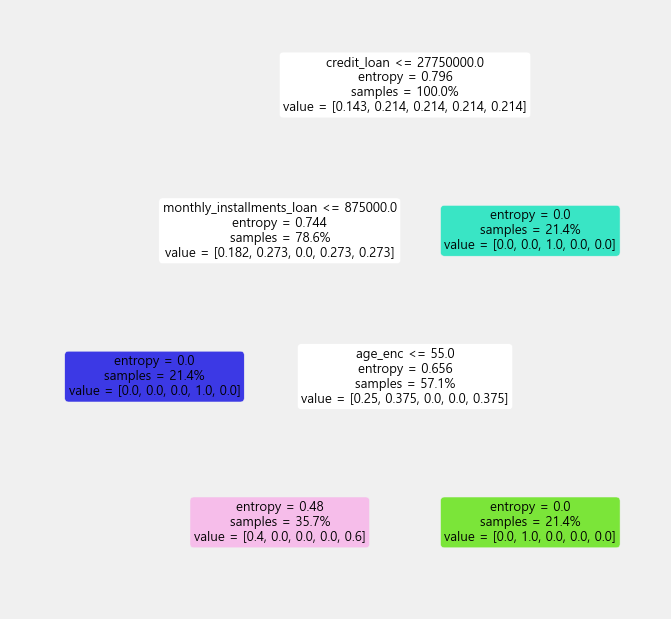

In [66]:
plt.figure(figsize=(10,10))
plot_tree(clf, feature_names=dt_features, filled=True, rounded=True, proportion='samples')
plt.show()

- 분류에 사용된 변수는 신용대출, 할부금융대출, 나이이다. 


- 군집0: 신용대출이 27,750,000원 이하이고, 할부금융업종 총 대출금액이 875,000원 이상이고, 나이가 55세 이하인 집단 중 40%
- 군집1: 신용대출이 27,750,000원 이하이고, 할부금융업종 총 대출금액이 875,000원 이상이고, 나이가 55세 이상인 집단
- 군집2: 신용대출이 27,750,000원 이상인 집단
- 군집3: 신용대출이 27,750,000원 이하이고, 할부금융업종 총 대출금액이 875,000원 이하인 집단
- 군집4: 신용대출이 27,750,000원 이하이고, 할부금융업종 총 대출금액이 875,000원 이상이고, 나이가 55세 이하인 집단 중 60%

### 지역별&연령별 특성
#### 1. 군집분석 결과
- 아래는 지역별&연령별 군집의 분포, 시간별 군집의 유형 변화를 시각화한 자료이다.

In [67]:
%%html
<div class='tableauPlaceholder' id='viz1562544841484' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;ci&#47;city_age&#47;6&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='city_age&#47;6' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;ci&#47;city_age&#47;6&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1562544841484');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.maxWidth='850px';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';vizElement.style.maxHeight='787px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

- 지역별&연령별로 보았을 때 수도권의 고연령대와 그 외 지역의 중간연령대가 같은 군집에 속한다. 
- 시간에 따라 지역별&연령별 군집의 유형 변화는 없었다.

#### 2. 인구수
- 아래는 지역별 인구수를 시각화한 자료이다.

In [68]:
barplots = list()
ages = credit_2.ages.unique()
city = credit_2.city.unique()
for c in city:
    bar_sex = Bar("연령별 {} 인구수".format(c), "단위: 천 명", width=800, height=400)
    bar_sex.add(c, ages, credit_2.loc[credit_2.city==c].groupby('ages').population.sum().values/1000, mark_point=['min','max'], mark_line=['average'])
    barplots.append(bar_sex)
timeline = Timeline(is_auto_play=True, timeline_bottom=0, timeline_play_interval='3000')
for i in range(len(barplots)):
    timeline.add(barplots[i], city[i])
timeline

- 30대가 가장 많은 지역은 서울 뿐이다.
- 40대가 가장 많은 지역이 인천, 대전, 대구, 광주, 울산, 경기, 충북, 충남, 전북, 제주
- 50대가 가장 많은 지역은 부산, 강원, 전남, 경북

#### 3. 업종별 대출금액 분포
- 아래는 군집별 대출업종의 대출금액을 비교하기위해 시각화한 자료이다.

In [69]:
region_class_num = 4
region_colors = ['orange','black','blue','red']
main = "군집별 대출업종 비교"
sub = '대출업종별 그룹의 지표 비교'
schemas = ['카드업종',' 보험업종','저축은행업종','할부금융업종','은행업종']
upjong = ['monthly_cd_loan','monthly_insurance_loan','monthly_sbk_loan','monthly_installments_loan','monthly_bk_loan']

radar_region = make_rader(credit_2, 
                          region_class_num,
                          upjong,
                          schemas,
                          False,
                          region_colors,
                          main,sub)
radar_region

- 군집0: 은행 이외에 업종에서는 대출이 거의 없다.
- 군집1: 은행 이외의 업종에서 대부분 대출이 있다.
- 군집2: 은행에서는 거의 대출을 금액이 없고, 저축은행에서 가장 대출금액이 많고, 다음이 할부금융업종이다.
- 군집3: 주로 카드업종, 은행, 할부금융업종에 골고루 있다.

#### 4. 신용/담보, 카드사용 관련 금액

In [70]:
main = "군집별 카드사용 관련 및 신용/담보대출 금액"
sub = '신용카드 사용 대비 신용/담보대출 금액 비교'
schemas = ['신용카드할부','신용카드일시불','월카드총금액','신용대출','담보대출']
cards = ['credit_card_installments_payment','credit_card_payment','monthly_card_spend','credit_loan','mortgage_loan']

In [71]:
radar_sex = make_rader(credit_2_raw, 
                       region_class_num,
                       cards,
                       schemas,
                       False,
                       sex_colors,
                       main,sub)
radar_sex

- 신용카드를 많이 사용한다고해서 담보대출보다 신용대출을 더 받진 않는다
    - 군집0: 신용카드는 거의 사용하지 않고 그에비해 담보대출과 신용대출금액은 높은 편이다.
    - 군집1: 신용카드를 모두 잘 사용하며 담보대출관 신용대출 또한 가장크다.
    - 군집2: 월카드 총 금액만큼 신용대출 또한 비슷한 금액이 있다.
    - 군집3: 군집1에 비해 신용카드를 절반정도밖에 사용하지 않고, 담보대출 금액이 가장 크다.

#### 5. 총 대출 관련 및 일시/분할상환 대출잔여금액

In [72]:
main = "군집별 총 대출관련 및 일시/분할상환 대출잔여금액"
sub = '총 대출관련 및 일시/분할상환 대출잔여금액 비교'
schemas = ['분할상환','일시상환','한도대출약정','총대출약정','총대출']
total= ['inst_rep_loanb','ls_rep_loanb','loan_commitment','monthly_lc','monthly_loan']

In [73]:
radar_sex = make_rader(credit_2_raw, 
                       region_class_num,
                       total,
                       schemas,
                       False,
                       sex_colors,
                       main,sub)
radar_sex

- 군집0: 다른 특성에 비해 분할상환 대출 잔여금이 없는 편이다.
- 군집1: 분할상환 대출잔여금이 가장 크다. 반면에 일시상환 대출잔여금과 한도대출 총 약정금액또한 작다.
- 군집2: 전체적으로 대출을 많이 하지도 않는다. 
- 군집3: 분할상환 대출잔여금은 다른 특성에 비해 적은 편이다. 한도대출 총 약정금액이 가장 많다.

In [74]:
%%html
<div class='tableauPlaceholder' id='viz1562544873422' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;ci&#47;city_age&#47;5&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='city_age&#47;5' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;ci&#47;city_age&#47;5&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1562544873422');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.maxWidth='850px';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';vizElement.style.maxHeight='787px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

- 군집1의 경우 저축은행업종 대출금액이 가장 많이 상승했다. 
- 군집2 또한 저축은행업종 대출금액이 상승했지만 다시 하락하였다.

#### 6. 머신러닝을 통한 군집별 해석


- 이번에는 의사결정나무를 통해서 각 군집별 특성을 해석해보도록 한다.

In [75]:
city_map = dict(zip(credit_2_raw.city.unique(), np.arange(credit_2_raw.city.nunique())))
credit_2_raw['city_enc'] = credit_2_raw.city.map(city_map)
credit_2_raw['age_enc'] = credit_2.ages.apply(lambda x: str(x)[:-1]).values

In [76]:
dt_features = ['city_enc','age_enc', 'population', 'num_opencard', 'num_usecard',
'monthly_card_spend', 'monthly_lc', 'monthly_loan', 'monthly_bk_loan',
'monthly_cd_loan', 'monthly_installments_loan',
'monthly_insurance_loan', 'monthly_sbk_loan', 'loan_commitment',
'inst_rep_loanb', 'ls_rep_loanb', 'credit_loan', 'mortgage_loan',
'credit_card_payment', 'credit_card_installments_payment']

In [77]:
credit_2_dummy = pd.concat([credit_2_raw[dt_features], pd.get_dummies(credit_2_raw['city'])], axis=1)
credit_2_dummy = credit_2_dummy.drop('city_enc', axis=1)

In [78]:
clf = DecisionTreeClassifier(max_depth=3, random_state=223)
clf.fit(credit_2_dummy, 
        credit_2_raw.label)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=223, splitter='best')

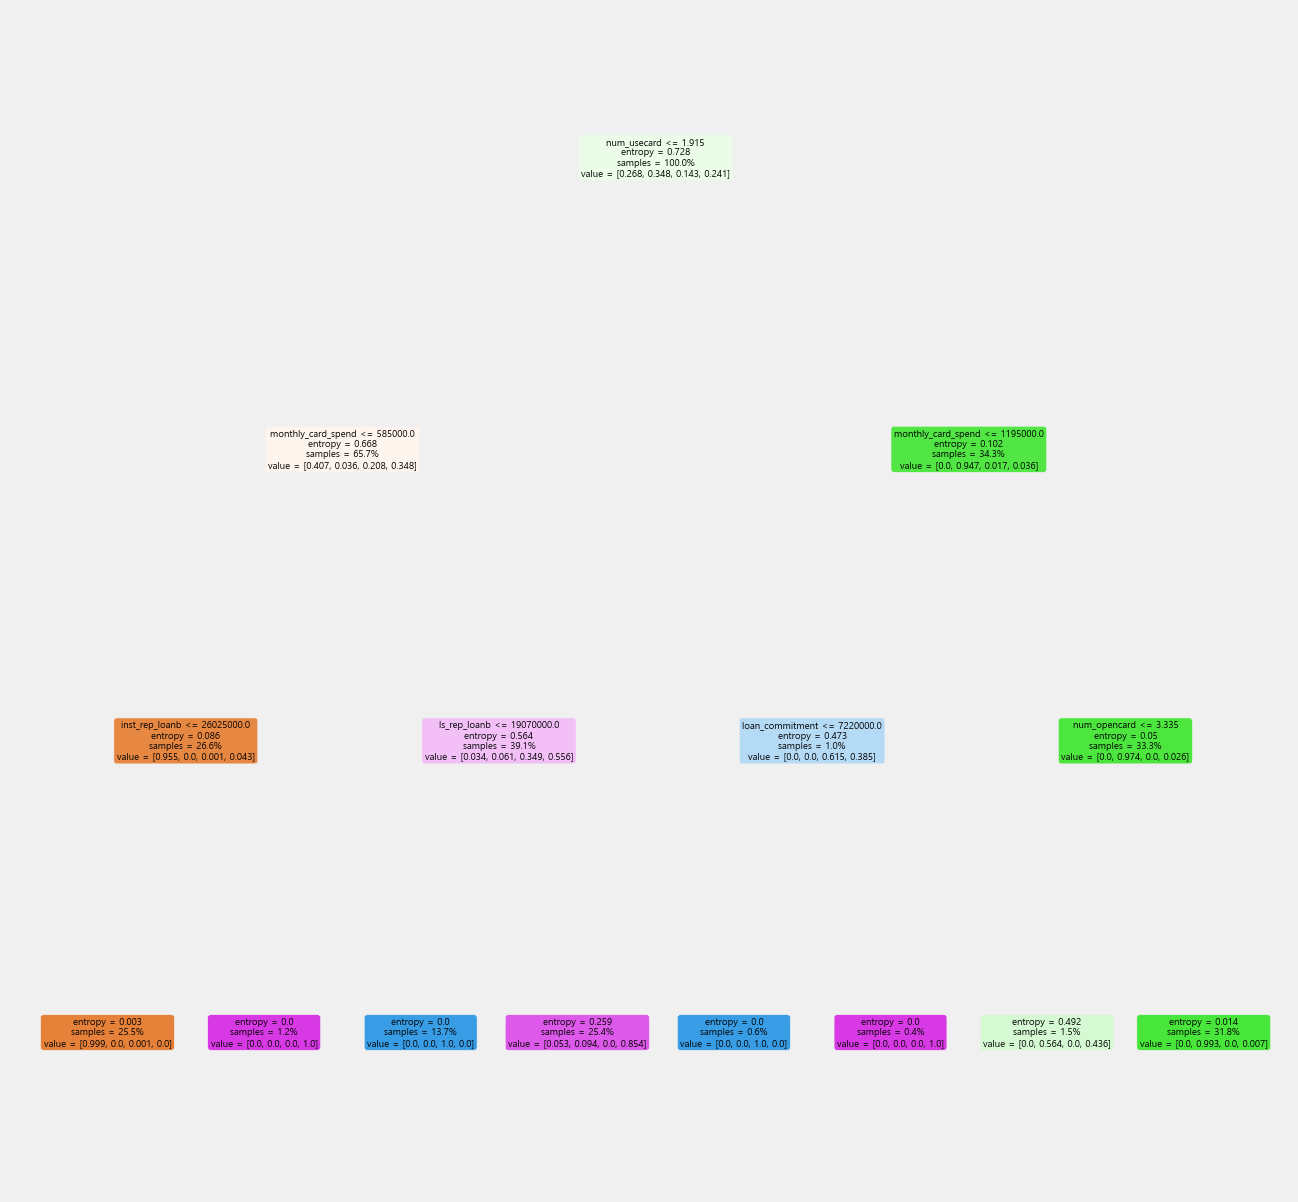

In [79]:
plt.figure(figsize=(20,20))
plot_tree(clf, feature_names=credit_2_dummy.columns, filled=True, rounded=True, proportion='samples')
plt.show()

- 분류에 사용된 변수는 사용 카드 수, 월 카드 사용금액, 분할상환 대출잔여금액, 일시상환 대출잔여금액, 한도대출 금액, 카드 개설 수이다.


- 군집0: 카드 사용수가 1.915개 이하, 월 카드 사용금액이 585,000원 이하, 분할상환 대출잔여금액이 26,025,000만원 이하인 집단
- 군집1: 카드 사용수가 1.915개 초과, 월 카드 사용금액이 1,195,000 초과, 카드 개설 수가 3.335개 초과인 집단 또는 이하인 집단의 56%
- 군집2: 카드 사용수가 1.915개 이하, 월 카드 사용금액이 585,000원 초과, 일시상환 대출잔여금액이 19,070,000만원 이하인 집단 또는 카드 사용수가 1.915개 초과, 월 카드 사용금액이 1,195,000 이하, 한도대출 금액이 7,220,000 이하인 집단
- 군집3: 카드 사용수가 1.915개 이하, 월 카드 사용금액이 585,000원 이하, 분할상환 대출잔여금액이 26,025,000만원 초과인 집단 또는 카드 사용수가 1.915개 이하, 월 카드 사용금액이 585,000원 초과, 일시상환 대출잔여금액이 19,070,000만원 초과인 집단 또는 카드 사용수가 1.915개 초과, 월 카드 사용금액이 1,195,000 이하, 한도대출 금액이 7,220,000 초과인 집단

# 결언(Conclussion)
- 지금까지 KCB에서 제공한 전 국민 카드 및 대출 이용통계 데이터를 이용하여 비슷한 특징을 가진 고객군들을 모으는 군집분석을 수행했다. 사용한 특성들은 카드 사용 관련, 대출에 관련된 특성을 사용했다. 분석을 수행하는 과정은 시간의 흐름에 따라 군집별 유형에 변화가 있는지 확인하기 위해 TimeSeries Clustering을 사용하였다. 이 과정 중에서는 어느 시점이 다른 여러시점의 영향을 받는다는 Dynamic Time Wrapping(DTW)를 이용하였다.

- 성별|연령별 데이터에서는 시간의 변화에 따라 고객 유형별 군집의 변화는 존재하지 않았다. 시간에 따른 대출금액 변화는 감소하는 구간이 존재했지만, 전체적인 트렌드는 지속해서 증가하는 추세를 보였다. 의사결정나무 모형을 이용해 각 군집별 특성을 해석해본 결과, 특성은신용대출, 할부금융업종대출, 연령대가 선택되었다. 같은 집단이 2개의 군집으로 나뉘었기 때문에 다소 아쉬운 결과를 보였다.
- 지역별|연령별 데이터에서는 시간의 변화에 따라 고객 유형별 군집의 변화는 존재하지 않았다. 특이한 점은 수도권의 고연령대(70~80대)와 그 밖의 중간연령대(50~60대)가 같은 군집에 속한다는 것을 알 수 있다.즉, 수도권에 사는 고연령대는 이외 지역에 사는 중간연령대의 대출 특징을 가지고 있다고 볼 수 있다. 시간에 따른 대출금액 변화는 감소하는 구간이 존재했지만, 전체적인 트렌드는 지속해서 증가하는 추세를 보였다.의사결정나무 모형을 이용해 각 군집별 특성을 해석해본 결과, 특성은 사용 카드 수, 월 카드 사용금액, 분할상환 대출잔여금액, 일시상환 대출잔여금액, 카드 개설 수가 선택되었다. 성별|연령별 데이터와는 달리 같은 집단이 여러 군집으로 나뉘는 결과는 보이지 않았다.

## 한계점

- 한편, KCB에서 제공한 전 국민 카드 및 대출 이용통계 데이터는 그룹별 평균화된 데이터로 가공되어졌다.그룹별 평균화된 데이터는 그룹 내 데이터의 일부가 극단적인 이상치를 가지더라도 평균으로 값을 가지기에, 일부 데이터의 값을 정확하게 반영하지 못하거나, 잘못된 판단을 할 가능성이 크다. 따라서 나눠진 군집에 개인 데이터로 재현화 시키기에는 다소 무리가 있다. 
- 정책상 카테고리 및 상환유형에 대한 필드가 일부 제거되었기 때문에 대출 총합의 비교가 어려움이 있다. 따라서 위의 군집분석을 활용하기 위해서는 새로운 필드가 필요해 보인다.